# <h2 align="center">DLOps - Configuração</h2>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Já temos uma idea do que é `DLOps` e como podemos versionar Datasets. Agora vamos treinar nossos primeiros modelos. Para essa tarefa usaremos a Biblioteca de [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/), uma biblioteca de código aberto que nos permite treinar modelos por acima de [Pytorch](https://pytorch.org/) oferecendo muitíssimas funcionalidades extras que nos fará a vida mais fácil na hora de treinar e gerenciar nossos modelos.


# Primeiro Treinamento

O seguinte código nos permite treinar um primeiro modelo com o Dataset `MNIST` que foi desenvolvido no script anterior. Como vimos, empezaremos fazendo um `classificador binário` simples que detecte apenas o dígito $3$ (mais para frente usaremos todo o Dataset para Classificação Multiclasse, aprendendo pelo caminho como gerar novas versões do Dataset e receitas de treinamento). O modelo que usaremos será um <font color="yellow">Perceptron Multicapa simples</font>.    

In [16]:
!pip install pytorch_lightning

/home/eddygiusepe/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/eddygiusepe/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [17]:
# Importando as nossas bibliotecas

import pytorch_lightning as pl 
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import torch 
import pandas as pd
from glob import glob

In [18]:
# Definimos nosso Dataset --> MNIST

class MSNITDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self): # Para saber quantas imagens temos
        return len(self.images)
    # Este método pega a imagem e traz ela com a sua respectiva Label
    def __getitem__(self, idx):
        img = imread(self.images[idx])
        return torch.from_numpy(img), self.labels[idx]


In [19]:
# Aqui processamos nossos Dados

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
    def generate_df(self, l1, l2):
        return pd.DataFrame({
            'image': l1 + l2, 
            'label': [1] * len(l1) + [0] * len(l2)
        })
    def setup(self, stage = None):
        train_3 = glob(str(self.path / 'train' / '3' / '*.png'))
        train_no3 = glob(str(self.path / 'train' / 'no3' / '*.png'))
        self.train_df = self.generate_df(train_3, train_no3)
        test_3 = glob(str(self.path / 'test' / '3' / '*.png'))
        test_no3 = glob(str(self.path / 'test' / 'no3' / '*.png'))
        self.test_df = self.generate_df(test_3, test_no3)
        self.train_ds = MSNITDataset(self.train_df.image.values, self.train_df.label.values)
        self.test_ds = MSNITDataset(self.test_df.image.values, self.test_df.label.values)
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.batch_size)
    def val_dataloader(self, batch_size=None, shuffle=False):
        return DataLoader(
            self.test_ds, 
            batch_size=self.batch_size if batch_size is None else batch_size,
            shuffle=shuffle
        )

In [20]:
from pathlib import Path


path = Path('dataset')

dm = MNISTDataModule(path, batch_size=25)
dm.setup()

imgs, labels = next(iter(dm.train_dataloader()))

imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels.shape

(torch.Size([25, 28, 28]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 torch.Size([25]))

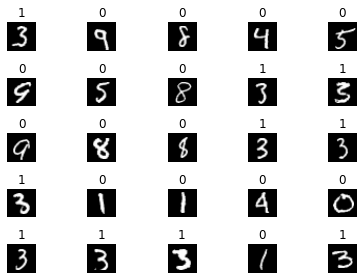

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


r, c = 5, 5 
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.train_dataloader()))
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        axs[i, j].set_title(labels[i * c + j].item())
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

# Label = 1 --> Quando o dígito é 3
# Label = 0 --> Quando o dígito não é 3

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class MNISTModule(pl.LightningModule):
    
    # Aqui contruímos a nossa REDE NEURAL simples --> MLP
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28 * 28, 100), # Conecta todos os pixels da Imagem com 100 neurônios
            nn.ReLU(), # Função de Ativação
            nn.Linear(100, 1) # 100 neurônios na capa oculta e com uma saída
        )
    
    # Recebe a imagem e a normaliza
    def forward(self, x):
        x = x.float() / 255 
        return self.mlp(x.view(x.size(0), -1)).squeeze(-1)
    
    # Para fazer predições
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid(self(x)) # valor entre zero e um --> Sigmoide

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float()) # Função de perda
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean() # Usaremos apenas accuracy
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

<font color="orange">Visualizamos as camadas de nossa Rede Neural Simples:</font>

In [23]:
module = MNISTModule()
module

MNISTModule(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [24]:
output = module(imgs)
output.shape

torch.Size([25])

In [26]:
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs=10,
    logger=None,
    enable_checkpointing=False,
    # overfit_batches=1, # Isto é recomendado. Ele vai aprender o Batch que você passar.
)


trainer.fit(module, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 78.6 K
------------------------------------
78.6 K    Trainable params
0         Non-trainable params
78.6 K    Total params
0.314     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


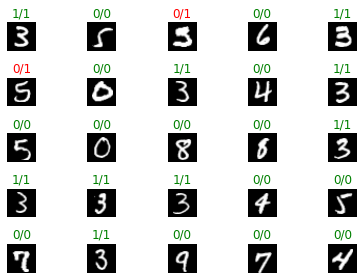

In [27]:
r, c = 5, 5 
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.val_dataloader(25, True)))
preds = module.predict(imgs) > 0.5
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        label = labels[i * c + j].item()
        pred = preds[i * c + j].long().item()
        axs[i, j].set_title(f'{label}/{pred}', color = 'green' if label == pred else 'red')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

# Script de Treinamento

Usar Notebooks é muito útil na hora de explorar nossos Dados e provar alguns modelos, mas na hora de escalar o treinamento precisaremos utilizar `script no Python`. Para isso te recomendo a seguinte distribuição de arquivos e pastas:

<font color="yellow">#############################################</font>
* `main.py` : contém o arquivo de treinamento

* `src` : contém os arquivos de código de Pytorch Lightning

    * `dm.py` : contém o LightningDataModule

    * `module.py` : contém o LightningModule

<font color="yellow">#############################################</font>


Para nosso primeiro caso é suficiente, mas a medida que um projeto vaja crescendo é possível que você queira adiconar arquivos na pasta `src`, <font color="orange">por exemplo</font> para separar os Datasets e modelos ou adicionar funcionalidades extra em um arquivo `utils.py`.


A seguir temos o código de treinamento (conteúdo do arquivo `main.py`)


In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl

path = Path('dataset')
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()

trainer = pl.Trainer(
    max_epochs=10,
    logger=None,
    enable_checkpointing=False,
    # overfit_batches=1,
)


trainer.fit(module, dm)

O arquivo `main.py` pode ser executado, assim:

```
python main.py
```

Isto treinará nosso modelo da mesma maneira que fizemos anteriormente. No entanto, isto não muito útil já que sempre treinaremos o mesmo modelo (o qual nem sequer estamos salvando). Precisamos dotar de flexibilidade a nosso `script` ademais de quer `trackear` todo o vamos fazendo. Isto é possível usando um arquivo de `configuração`. 


# Arquivo de `configuração`

Existe diferentes opções na hora de executar treinamentos com arquivos de configuração. Uma biblioteca bastante utilizada é [Hydra](https://hydra.cc/docs/intro/). Neste script seguirei a metodologia do `Data Scientist SENSIO`.

## Configuração base

O primeiro que precisamos é uma configuração base na que definiremos todos os parâmetros por default que queremos usar em nosso treinamento. 

In [ ]:
config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'logger': None,
        'enable_checkpointing': False,
        'overfit_batches': 0
    }
}

dm = MNISTDataModule(**config['datamodule'])
module = MNISTModule()
trainer = pl.Trainer(**config['trainer'])


trainer.fit(module, dm)

Usando o operador `**` pdoemos passar um dicionário de parâmetros a uma função.

<font color="pink">OBS:

Eu recomendo não usar parâmetros por defeito em teus `modules`, já que isto pode provocar problemas a longo prazo. É um pouco mais tedioso porém vale a pena para `trackear` todos os parâmetros usados no treinamento. 
</font>

# Sobreescrever a configuração base

Agora o que faremos será criar um arquivo `config.yml` que contenha a configuração que queremos usar em nosso treinamento. Para não ter que escrever todo o código de configuração, simplesmente definiremos aqueles parâmetros que modificar da configuração base. Desta maneira, nosso projeto ficará assim:

<font color="yellow">#############################################</font>
* `main.py` : contém o arquivo de treinamento

* `config.yml` : contém a configuração de treinamento

* `src` : contém os arquivos de código de Pytorch Lightning

    * `dm.py` : contém o LightningDataModule

    * `module.py` : contém o LightningModule

    * `utils.py` : contém funções úteis

<font color="yellow">#############################################</font>


O seguinte exemplo fará um treinamento com mais `epochs` e com um `batch_size` mais grande:

```
datamodule:
  batch_size: 32

trainer:
  max_epochs: 20
```  

Em nosso script de treinamento, simplesmente carregaremos a configuração do arquivo, sobreescrevendo a configuração base e executaremos o treinamento.

In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl
import yaml
import sys

config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'logger': None,
        'enable_checkpointing': False,
        'overfit_batches': 0
    }
}


def train(config):
    dm = MNISTDataModule(**config['datamodule'])
    module = MNISTModule()
    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)


if __name__ == '__main__':
    if len(sys.argv) > 1:
        config_file = sys.argv[1]
        if config_file:
            with open(config_file, 'r') as stream:
                loaded_config = yaml.safe_load(stream)
            deep_update(config, loaded_config)
    print(config)
    train(config)

# Gerando diferentes experimentos

Com este `setup` já temos todo o necessário para gerar diferentes experimentos. Simplesmente faremos um arquivo de configuração novo para cada experimento que desejemos executar. Desta maneira, sempre teremos na mão os hiperparâmetros usados em um treinamento para poder comparar resultados e ficar com os melhores. Um projeto típico terá a seguinte estrutura:

- `main.py` : contém o código de treinamento.

- `src` : contém os arquivos de código de Pytorch Lightning.

    - `dm.py` : contém o LightningDataModule.

    - `module.py` : contém o LightningModule.

    - `utils.py` : contém funções úteis.

- `experiments` : contém os arquivos de configuraço dos experimentos.

    - `001.yml` : contém a configuração do treinamento 1.
    - `002.yml` : contém a configuração do treinamento 2.
    - `003.yml` : contém a configuração do treinamento 3.
    - ...
    - `debug.yml` : contém a configuração do treinamento para debug.

> Eu aconselho ter um arquivo de `debug.yml` o qual te permitirá fazer o fit de uns batches para comprovar que teu código funciona bem.


Pode executar os experimentos com o comando:

```
python main.py experiments/001.yml
```








# Conselhos finais 

Para ter o máximo de proveito de nosso sistema de configuração, te aconselho usar uma funcionalidade de `Pytorch Lightning` muito útil, que é a de salvar os hiperparâmetros no mesmo `checkpoint` do modelo.

In [ ]:
class MNISTModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        # ...

Desta maneira, ao carregar qualquer modelo que hajas treinado com este sistema, poderás acessar aos hiperparâmetros que usaste no treinamento.

In [ ]:
# ...

def train(config):
    dm = MNISTDataModule(**config['datamodule'])
    module = MNISTModule(config)
    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)
    trainer.save_checkpoint('final.ckpt')

# ...

In [ ]:
from src import MNISTModule

module = MNISTModule.load_from_checkpoint('final.ckpt')
module.hparams

No seguinte script veremos como melhorar nosso script de treinamento para adicionar funcionalidades interessantes no ciclo de DLOPs tais como `trackear` os resultados dos experimentos de maneira efetiva, salvar e versionar os modelos treinados para poder colocá-los em produção.